<a href="https://colab.research.google.com/github/MarinaChau/IASD_classes/blob/master/Criteo/Copy_of_GANs_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
from random import shuffle
import time
import os

In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm_notebook

from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, \
  Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, \
  LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist, fashion_mnist

We are going to use FashionMNIST for this session. The objective will be to build a generative adversarial network for this dataset.

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

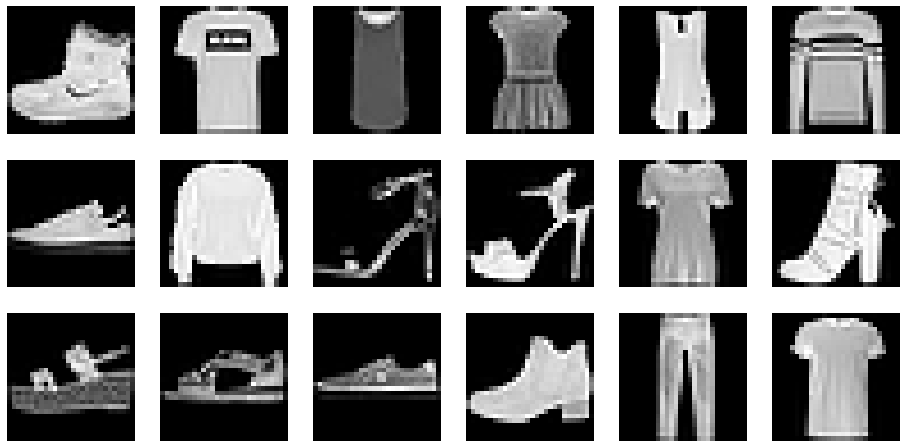

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
original_dim = 784
seed_dim = 32
intermediate_dim = 256
batch_size = 8

In [ ]:
def adam_optimizer(lr=0.0001):
    return tf.keras.optimizers.Adam(lr=lr, beta_1=0.5)

## A) Generator

In [ ]:
# Exercise:
# * create a simple fully-connected generator that takes noise as input and generate an image
# * plot the output of the generator for some input sample
# * Hint: we need pixels between -1 and 1. What is the correct activation for the last layer ?

def create_generator():
    
    #### YOUR CODE HERE
    inp = Input(shape=(seed_dim,))

    model = Model(
        inputs=inp,
        outputs=out,
        name="generator"
    )
    ####

    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return model

In [ ]:
generator = create_generator()
print(generator.summary())

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_3 (Dense)             (None, 256)               8448      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 784)               402192    
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 1)         0 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def test_generator(generator):
    """
    Test that the generator generates the correct shape
    """
    seed = tf.random.normal(shape=(batch_size, seed_dim),
                            mean=0., stddev=1.)
    data = generator(seed).numpy()
    
    if data.shape != (batch_size, 28, 28, 1):
        raise RuntimeError(f"Shape is {data.shape} (expected {(batch_size, 28, 28, 1)})")
    
test_generator(generator)

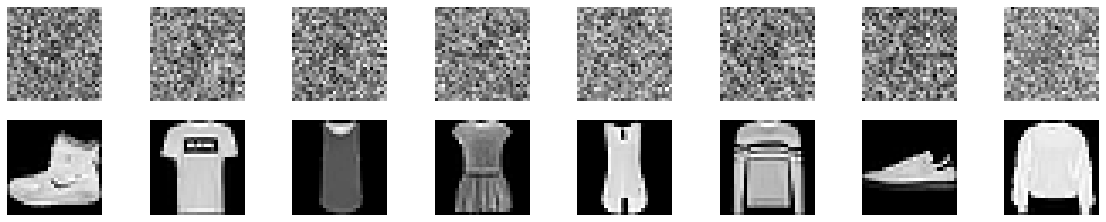

In [ ]:
####
def generate_and_plot(generator, inputs=None):
    
    if inputs is None:
        real_images = x_train[:8]
    else:
        real_images = inputs

    real_images = real_images.reshape((-1, 28, 28, 1))
    seed = tf.random.normal(shape=(batch_size, seed_dim),
                            mean=0., stddev=1.)

    data = generator(seed).numpy()
    data = np.concatenate(
        (data, real_images), axis=0)

    plt.figure(figsize=(20, 8))
    for i in range(0, 16):
        plt.subplot(4, 8, i + 1)
        plt.imshow(data[i, :].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()
    
generate_and_plot(generator)
####

## B) Discriminator

In [ ]:
# Exercise:
# * Create a simple fully-connected discriminator model
#   using a funnel 512 -> 256 -> 128
# * Train it to check that it can easily make the difference between 
#   your random generator and the real images

def create_discriminator() -> Model:
    
    #### YOUR CODE HERE
    inp = Input(shape=(28, 28, 1))
    
    model = Model(inputs=inp, outputs=out, name="discriminator")
    ####
    
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return model

In [ ]:
discriminator = create_discriminator()
print(discriminator.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
n_train = 1000
seed = tf.random.normal(shape=(n_train, seed_dim), mean=0., stddev=1.)
fake_data = generator(seed).numpy()
discr_train = tf.concat([x_train[:n_train].reshape(-1, 28, 28, 1), fake_data], axis=0)
y_train = np.concatenate([np.zeros(n_train), np.ones(n_train)])

seed = tf.random.normal(shape=(10000, seed_dim), mean=0., stddev=1.)
fake_data = generator(seed).numpy()
discr_test = tf.concat([x_test.reshape(-1, 28, 28, 1), fake_data], axis=0)
y_test = np.concatenate([np.zeros(10000), np.ones(10000)])
print(discr_test.shape)

(2000, 28, 28, 1)
(20000, 28, 28, 1)


In [ ]:
discriminator.fit(x=discr_train, y=y_train)

63/63 [==============================] - 2s 4ms/step - loss: 0.1954


In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_score=discriminator.predict(discr_test), y_true=y_test)
print(f"AUC is {auc}")

AUC is 1.0


## C) GAN model training

In [ ]:
def training(
    iter=2,
    batch_size=128,
    discr_func=create_discriminator,
    gen_func=create_generator,
    seed_dim=seed_dim,
):

    # Creating GAN
    generator= gen_func()
    discriminator= discr_func()
    
    #gan = create_gan(discriminator, generator)

    generator_opt = tf.keras.optimizers.Adam(1e-4)
    discriminator_opt = tf.keras.optimizers.Adam(1e-4)
    start_time = time.time()
    losses_generator = list()
    losses_discriminator = list()

    for my_iter in range(iter):
        #Loading the batch
        real_iter = my_iter % (len(x_train)//batch_size)
        real_data  = x_train[real_iter*batch_size:(real_iter+1)*batch_size]
        real_data = real_data.reshape(-1, 28, 28, 1)

        # Train discriminator
        with tf.GradientTape() as d:
          d.watch(discriminator.trainable_variables)
          #### Discriminator loss HERE
          #loss_discriminator = ??

          # Backward pass
          grads = d.gradient(loss_discriminator, discriminator.trainable_variables)
          discriminator_opt.apply_gradients(
              zip(grads, discriminator.trainable_variables)
          )
        losses_discriminator.append(loss_discriminator)

        # Train generator
        noise = np.random.normal(0, 1, [batch_size, seed_dim])
        with tf.GradientTape() as g:
          g.watch(generator.trainable_variables)
          #### Generator loss HERE
          #loss_generator = ?? 
          grads = g.gradient(loss_generator, generator.trainable_variables)
          generator_opt.apply_gradients(
              zip(grads, generator.trainable_variables)
          )
        losses_generator.append(loss_generator.numpy())

        if my_iter % 100 == 0:
            clear_output()
            print(f"Iter {my_iter} ({real_iter})")
            if start_time is not None:
                time_spent = time.time() - start_time
                print(f"(Avg {time_spent/100} seconds per iteration)")
            start_time = time.time()
            #print(my_iter, loss_discriminator, tf.reduce_mean(d_real), tf.reduce_mean(d_fake))
            generate_and_plot(generator, real_data)
        
    return losses_generator, losses_discriminator

In [ ]:
#EXERCISES
#1) Write code for GANs
#2) Add soft labels 
#3) Write both Vanilla GANs and non-saturated GANs

Iter 400 (400)
(Avg 0.05514056205749512 seconds per iteration)
400 tf.Tensor(0.00022779644, shape=(), dtype=float32) tf.Tensor(0.99977356, shape=(), dtype=float32) tf.Tensor(2.7099503e-10, shape=(), dtype=float32)


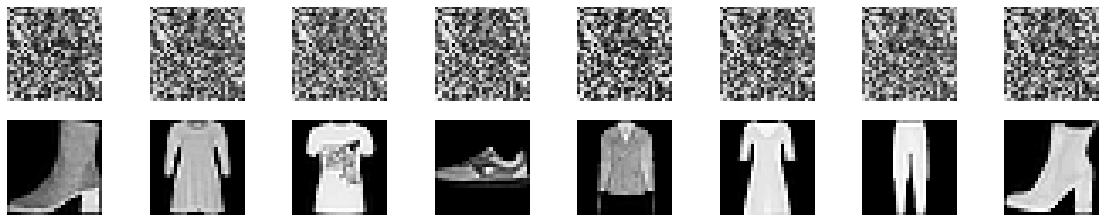

SystemError: ignored

In [ ]:
losses_generator, losses_discriminator = training(10000, 64)

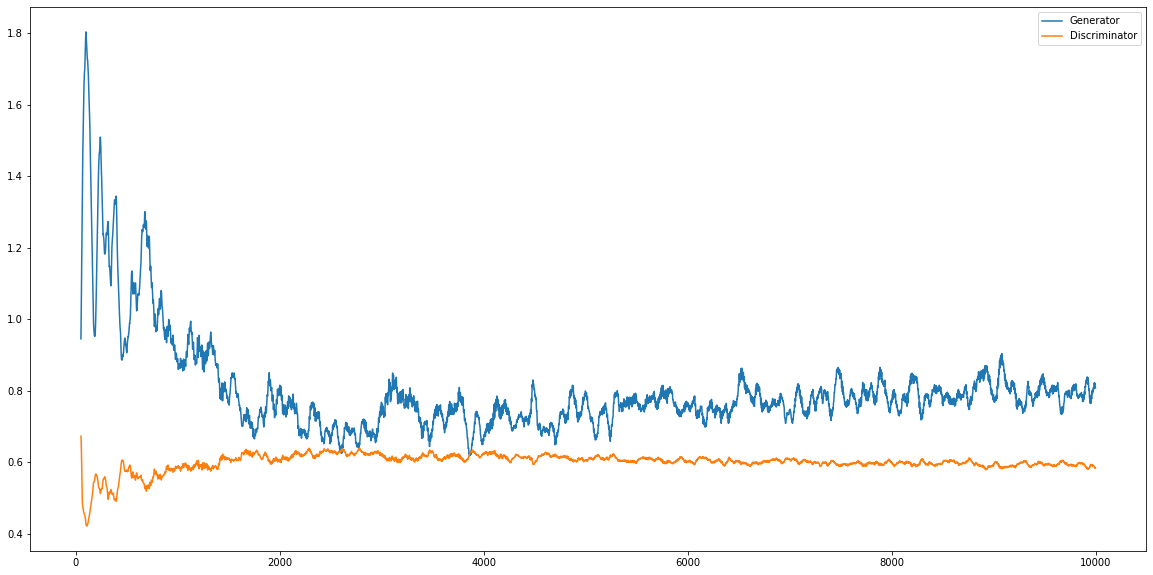

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.subplots()
ax.plot(pd.Series(losses_generator).rolling(50).mean(), label="Generator")
ax.plot(pd.Series(losses_discriminator).rolling(50).mean(), label="Discriminator")
plt.legend()
fig.show()

## D) Switching to CNNs

In [ ]:
def create_generator_cnn(seed_dim=seed_dim):    
    inp = Input(shape=(seed_dim,))
    
    x = Dense(7*7*256, use_bias=False)(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Reshape((7, 7, 256))(x)
    x = Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')(x)
    
    model = Model(
        inputs=inp,
        outputs=x,
        name="generator"
    )
    
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return model

create_generator_cnn().summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_123 (Dense)           (None, 12544)             401408    
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_90 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_19 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def create_discriminator_cnn():
    inp = Input(shape=(28, 28, 1))
    #Create small Conv2D discriminator with Conv2D function...

    model = Model(
        inputs=inp,
        outputs=out,
        name="discriminator"
    )

    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return model

create_discriminator_cnn().summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_93 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_34 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_94 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_35 (Dropout)        (None, 7, 7, 128)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#EXERCISE: Train the CNN Gan: What do you observe ?

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.subplots()
ax.plot(pd.Series(losses_generator_cnn).rolling(30).mean(), label="Generator")
ax.plot(pd.Series(losses_discriminator_cnn).rolling(30).mean(), label="Discriminator")
plt.legend()
fig.show()

## E) OPT. Wasserstein Gan

Exercise: Implement a Wasserstein Gan


In [ ]:
# EXERCISE: Implement the training of the wGAN.

def gradient_penalty(discriminator, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = discriminator(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

def training_wasserstein(
    iter=2,
    batch_size=128,
    discr_func=create_discriminator,
    gen_func=create_generator,
    seed_dim=seed_dim,
    cnn = True
):

    # Creating GAN
    generator= gen_func()
    discriminator= discr_func()
    gradient_penalty_weight = 10
    generator_opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    discriminator_opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    start_time = time.time()
    losses_generator = list()
    losses_discriminator = list()

    for my_iter in range(iter):

        #Loading the batch
        real_iter = my_iter % (len(x_train)//batch_size)
        real_data  = x_train[real_iter*batch_size:(real_iter+1)*batch_size]
        real_data = real_data.reshape(-1, 28, 28, 1)

        # Train discriminator
        noise = np.random.normal(0, 1, [batch_size, seed_dim])
        generated_images = generator(noise)
        with tf.GradientTape() as g:
          g.watch(discriminator.trainable_variables)
          #### Discriminator loss HERE
          
          #loss_discriminator = ??
          grads = g.gradient(-loss_discriminator, discriminator.trainable_variables)
          discriminator_opt.apply_gradients(
              zip(grads, discriminator.trainable_variables)
          )
        losses_discriminator.append(loss_discriminator.numpy())
        
        # Train generator
        noise = np.random.normal(0, 1, [batch_size, seed_dim])
        with tf.GradientTape() as g:
          g.watch(generator.trainable_variables)
          #### Generator loss HERE
          #loss_generator = ??
          grads = g.gradient(-loss_generator, generator.trainable_variables)
          generator_opt.apply_gradients(
             zip(grads, generator.trainable_variables)
          )
        losses_generator.append(loss_generator.numpy())
        
        if my_iter % 100 == 0:
            clear_output()
            print(f"Iter {my_iter} ({real_iter})")
            if start_time is not None:
                time_spent = time.time() - start_time
                print(f"(Avg {time_spent/100} seconds per iteration)")
            start_time = time.time()
            generate_and_plot(generator, real_data)
        
    return losses_generator, losses_discriminator

In [ ]:
#EXERCISE: Launch training WGANs with fully connected layers and CNNs...
#EXERCISE: Launch training Vanilla GANs with regularization...

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.subplots()
ax.plot(pd.Series(losses_generator_w).rolling(30).mean(), label="Generator")
ax.plot(pd.Series(losses_discriminator_w).rolling(30).mean(), label="Discriminator")
plt.legend()
fig.show()